In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def density_plot(col, fs=15):
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.grid()
    
    subset = df[df['label'] == 0]
    sns.distplot(subset[col], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Low Prevalence", 
                 color = "blue")

    subset = df[df['label'] == 1]
    sns.distplot(subset[col], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "High Prevalence", 
                 color = "red")
    
    # Plot formatting
    plt.legend(prop={'size': 10}, title = 'Group')
    plt.title('Density Plot of '+col, fontsize=fs)
    plt.xlabel(col, fontsize=fs)
    plt.ylabel('Density', fontsize=fs)

In [4]:
df = pd.read_csv("data/Merged_5_Cleaned_Cluster.csv")
df_test = pd.read_csv("data/test_data.csv")

In [5]:
df.shape

(147, 74)

In [6]:
# filter out small sample size
df = df[df["Total"] >= 10]
df.shape

(147, 74)

In [7]:
df = df.sort_values(by=["Percentage"], ascending=False)

In [8]:
df.head()

,Species,Total,Positive,Percentage,MSW05_Family,MSW05_Genus,8-1_AdultForearmLen_mm,12-1_HabitatBreadth,26-1_GR_Area_km2,26-2_GR_MaxLat_dd,...,earth9_urban,gens,mamdiv,pubs_fit,crop,past,pop,crop_change,past_change,pop_change
0,Miniopterus inflatus,12,7,0.583333,Vespertilionidae,Miniopterus,48.090,1,2563885.05,9.38,...,0.057122,105.099840,127.463820,2.222718,0.063315,0.256668,3.099492e+05,0.002251,0.003346,75523.242633
1,Ptenochirus jagori,83,27,0.325301,Pteropodidae,Ptenochirus,84.340,1,248720.14,19.00,...,0.246348,114.235274,49.800000,4.404413,0.293120,0.003312,1.094543e+06,-0.005932,0.000530,214910.691134
2,Rhinopoma hardwickii,299,93,0.311037,Rhinopomatidae,Rhinopoma,59.500,1,16925604.79,36.49,...,0.189466,104.417372,55.647391,4.414228,0.131694,0.171981,7.019647e+05,0.004819,-0.000308,134545.262467
3,Myotis occultus,17,5,0.294118,Vespertilionidae,Myotis,38.155,1,737413.10,28.57,...,0.064151,110.466127,18.783734,2.130000,0.004535,0.036499,7.486260e+04,0.000478,0.000844,15646.242662
4,Pipistrellus kuhlii,494,138,0.279352,Vespertilionidae,Pipistrellus,34.690,1,4765557.66,47.99,...,0.372475,92.435932,38.356326,8.008936,0.126324,0.210289,3.720022e+05,-0.001645,0.002944,54228.614878


In [9]:
# define prevalence rate > 0.05 as high, data points will be divided into roughly half
df["label"] = [1 if p >= 0.05 else 0 for t,p in zip(df["Total"], df["Percentage"])]
df["c"] = ["#FF0000" if l == 1 else "#0000FF" for l in df["label"]]

In [10]:
sum(df["label"]) / len(df)

0.4557823129251701

In [11]:
# transformation
df["log_27-2_HuPopDen_Mean_n/km2"] = np.log(df["27-2_HuPopDen_Mean_n/km2"].values)
df["28-2_Temp_Mean_01degC_2"] = df["28-2_Temp_Mean_01degC"].values ** 2
df_test["28-2_Temp_Mean_01degC_2"] = df_test["28-2_Temp_Mean_01degC"].values ** 2

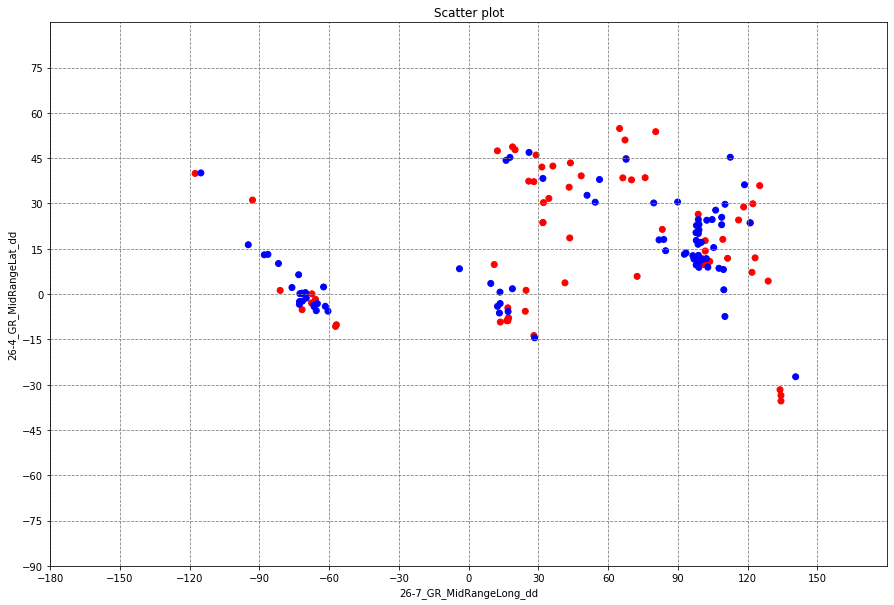

In [15]:
# bat location plot
cols = ['26-7_GR_MidRangeLong_dd', '26-4_GR_MidRangeLat_dd']
X = df[cols].values

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.grid()
ax.set_xticks(np.arange(-180, 180, 30))
ax.set_yticks(np.arange(-90, 90, 15))
plt.rc('grid', linestyle="--", color='grey')
plt.title("Scatter plot")
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.scatter(X[:,0], X[:,1], c=df["c"])

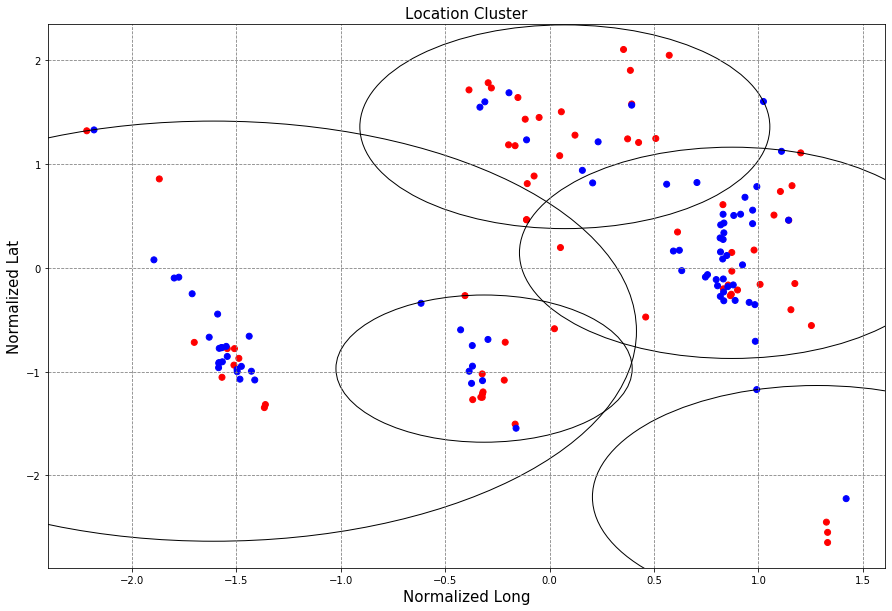

In [16]:
# create location cluster
def dist(X, center):   
    return [np.sqrt(np.sum((x-center)**2)) for x in X]

X = df[cols].values
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

kmeans = KMeans(5)
kmeans.fit(X_std)
labels = kmeans.predict(X_std)
centers = kmeans.cluster_centers_
radii = [max(dist(X_std[labels==i], center)) for i, center in enumerate(centers)]

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(X_std[:, 0], X_std[:, 1], c=df["c"].values)
ax.set_title("Location Cluster", fontsize=15)
ax.set_xlabel("Normalized Long", fontsize=15)
ax.set_ylabel("Normalized Lat", fontsize=15)
for i, center in enumerate(centers):
    ax.add_artist(plt.Circle(center, radii[i], fill=False))
ax.grid()

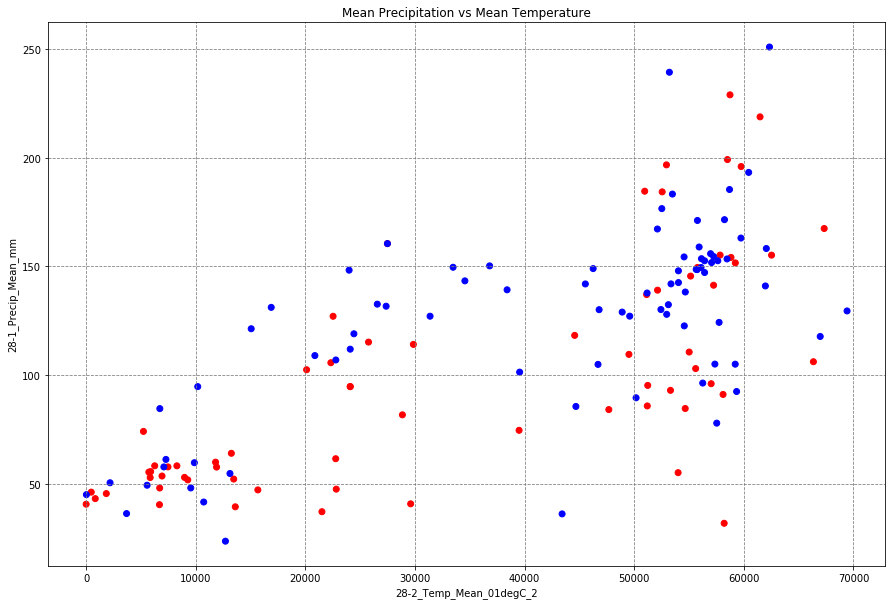

In [19]:
# mean temperature & mean precipitation
cols = ['28-2_Temp_Mean_01degC_2', '28-1_Precip_Mean_mm']
X = df[cols].values

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.grid()
plt.rc('grid', linestyle="--", color='grey')
plt.title("Mean Precipitation vs Mean Temperature")
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.scatter(X[:,0], X[:,1], c=df["c"])

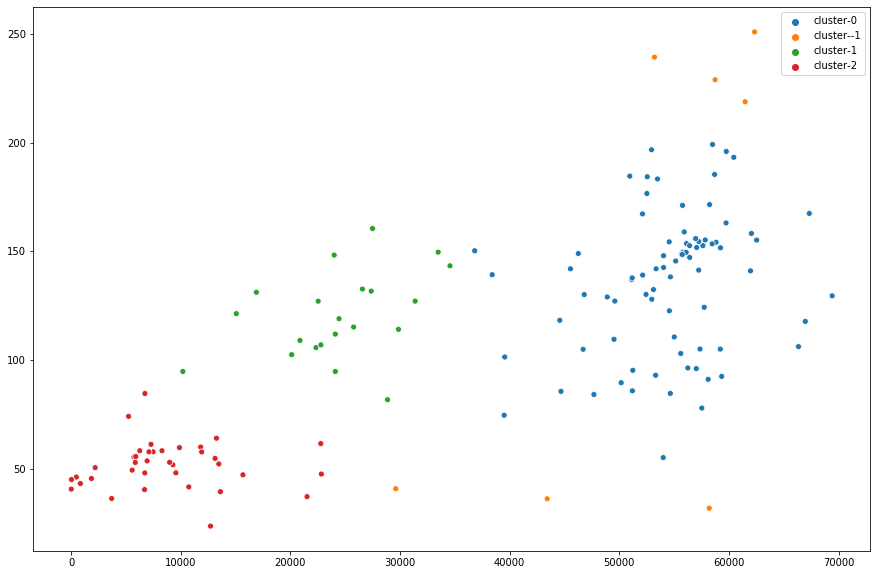

In [20]:
# DBSCAN
from sklearn.cluster import DBSCAN

X = df[cols].values
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

db = DBSCAN(eps=0.5, min_samples=10).fit(X_std)
labels = db.labels_
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(X[:,0], X[:,1], hue=["cluster-{}".format(x) for x in labels])